# Examples - Delayed
http://dask.pydata.org/en/latest/examples-tutorials.html#delayed

In [7]:
import os, h5py, dask

data_path = '../dask-tutorial/data'

## Build Custom Arrays
Here we have a serial blocked computation for computing the mean of all positive elements in a large, on disk array:

In [3]:
filename = 'myfile.hdf5'
file = os.path.join(data_path, filename)

In [2]:
dset = h5py.File(file)['/x']          # Trillion element array on disk
dset

<HDF5 dataset "x": shape (1000000,), type "<f4">

In [3]:
total_size = dset.shape[0]
chunks = dset.chunks[0]
block_size = total_size // chunks

sums = []
counts = []

for i in range(chunks):                    # One million times
    chunk = dset[block_size*i:block_size*(i + 1)]    # Pull out chunk
    positive = chunk[chunk > 0]             # Filter out negative elements
    sums.append(positive.sum())             # Sum chunk
    counts.append(positive.size)            # Count chunk

result = sum(sums) / sum(counts)            # Aggregate results
result

1.0016021365966796

In [4]:
dset.file.close()

Below is the same code, parallelized using dask.delayed:

In [4]:
from dask import delayed

h5file = delayed(h5py.File)(file)  # Trillion element array on disk
dset = h5file['/x']

total_size = dset.shape[0]
chunks = dset.chunks[0]
block_size = total_size // chunks

sums = []
counts = []

for i in range(chunks.compute()):                    # One million times
    chunk = dset[block_size*i:block_size*(i + 1)]    # Pull out chunk
    positive = chunk[chunk > 0]             # Filter out negative elements
    sums.append(positive.sum())             # Sum chunk
    counts.append(positive.size)            # Count chunk

# result = sum(sums) / sum(counts)                      # Aggregate results    
result = delayed(sum)(sums) / delayed(sum)(counts)    # Aggregate results
result  

Delayed('truediv-c57c09393428613b1d733e1a897d959b')

In [5]:
result.compute()

1.0016021365966796

In [6]:
h5file.compute().close()

Only 3 lines had to change to make this computation parallel instead of serial.

- Wrap the original array in delayed. **This makes all the slices on it return Delayed objects.**
- Wrap both calls to sum with delayed.
- Call the compute method on the result.  

While the for loop above still iterates fully, it’s just building up a graph of the computation that needs to happen, without actually doing any computing.

## Data Processing Pipelines
Example notebook.

Now, rebuilding the example from custom graphs:

In [8]:
from dask import delayed
@delayed
def load(filename):
    return filename + ' loaded'

@delayed
def clean(data):
    return data + ' cleaned'

@delayed
def analyze(sequence_of_data):
    return str(sequence_of_data) + ' analyzed'

@delayed
def store(result):
#     with open(..., 'w') as f:
#         f.write(result)
    return result + ' stored'

files = ['myfile.a.data', 'myfile.b.data', 'myfile.c.data']
loaded = [load(i) for i in files]
cleaned = [clean(i) for i in loaded]
analyzed = analyze(cleaned)
stored = store(analyzed)
stored

Delayed('store-7f376308-21b3-427e-a9ee-6be66db0edba')

In [9]:
stored.compute()

"['myfile.a.data loaded cleaned', 'myfile.b.data loaded cleaned', 'myfile.c.data loaded cleaned'] analyzed stored"

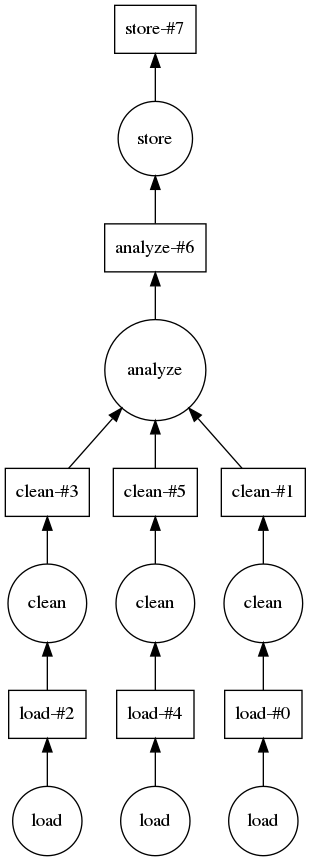

In [10]:
stored.visualize()